In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from matplotlib import pyplot as plt

In [ ]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


#Data exploratory analysis

In [ ]:
# check the shape of train and test datasets
print(train_data.shape)
print(test_data.shape)


(60000, 28, 28)
(10000, 28, 28)


In [ ]:
import numpy as np
np.unique(train_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

There are 10 categories with 6000 each, in the training dataset.

####Data Preprocsseing

Most clustering algorithms take 1-D array as input, so do transformation on the original dataset(flatten)

In [ ]:
# transform data into 1-D
train_x = train_data.reshape(train_data.shape[0], -1).astype('float32')
test_x = test_data.reshape(test_data.shape[0], -1).astype('float32')

# standardization
train_x = train_x/train_x.max()
test_x = test_x/test_x.max()
print(train_x.shape)

(60000, 784)


####Visualization

In [ ]:
# Name the lables
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


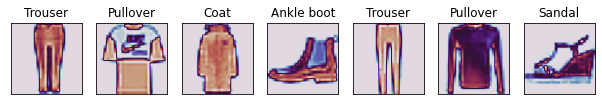

In [ ]:
# Randomly choose some images
import random
random.seed(9)

fig = plt.figure(figsize=[12, 8])
cnt=1
for i in random.sample(range(0, 60000), 7):
  ax = fig.add_subplot(1, 8, cnt+1, xticks=[], yticks=[])
  ax.imshow(train_data[i], cmap="twilight")
  ax.set_title(str(labels[train_labels[i]]))
  cnt=cnt+1

##Unsupervised Learning
#### Mini-Batch KMeans

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

In [ ]:
k_cluster=MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=50, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=542,
                reassignment_ratio=0.008, tol=0.0, verbose=0)

In [ ]:
k_cluster.fit(train_x)

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(max_iter=50, n_clusters=10, random_state=542,
                reassignment_ratio=0.008)

In [ ]:
label2cluster = {}

for i in range(k_cluster.n_clusters):
    labels = []
    indeces = np.where(k_cluster.labels_ == i)
    labels.append(train_labels[indeces])

For each y_label, check which category they are mostly concentrated in

In [ ]:
def get_label2cluster_mapper(kmeans, ground_trues):

    label2cluster = {}
    for i in range(kmeans.n_clusters):
        labels = []
        indeces = np.where(kmeans.labels_ == i)
        labels.append(ground_trues[indeces])
        #labels = ground_trues[indeces]
        #hist = (np.bincount(np.squeeze(labels)))
        
        if len(labels[0]) == 1:
            hist = np.bincount(labels[0])
        else:
            hist = np.bincount(np.squeeze(labels))

        if np.argmax(hist) in label2cluster:
            label2cluster[np.argmax(hist)].append(i)
        else:
            label2cluster[np.argmax(hist)] = [i]

    return label2cluster

In [ ]:
get_label2cluster_mapper(k_cluster, train_labels)

{5: [0], 6: [1], 2: [2], 9: [3, 4], 0: [5], 1: [6], 8: [7], 4: [8], 7: [9]}

## LightGBM

In [ ]:
from sklearn import metrics
import lightgbm as ltg
from sklearn.model_selection import cross_val_score
import time
start_time = time.time()

Light gradient bosting model fitting

In [ ]:
ltg_model =ltg.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_class=10, num_iteration=100, max_depth=4, learning_rate=0.01, n_estimators=100, n_thread=4, slient=False)

In [ ]:
cv_results = cross_val_score(ltg_model, train_x, train_labels, cv=2, scoring='accuracy', n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.2min finished


In [ ]:
ltg_model.fit(train_x, train_labels)

LGBMClassifier(objective='multiclass')

In [ ]:
print(cv_results)    
print(ltg_model)

[0.82833333 0.83206667]
LGBMClassifier(learning_rate=0.01, max_depth=4, n_thread=4, num_class=10,
               num_iteration=100, objective='multiclass', slient=False)


In [ ]:
expected_y  = test_labels
predicted_y = ltg_model.predict(test_x)
print(metrics.classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1000
           1       0.99      0.91      0.95      1000
           2       0.70      0.74      0.72      1000
           3       0.78      0.88      0.83      1000
           4       0.67      0.75      0.71      1000
           5       0.98      0.88      0.93      1000
           6       0.66      0.48      0.56      1000
           7       0.87      0.92      0.89      1000
           8       0.94      0.93      0.93      1000
           9       0.88      0.94      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



# LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
lda = LDA(n_components=9)
lda_model = lda.fit(train_x, train_labels)
pred = lda_model.predict(test_x)
pred

array([9, 2, 1, ..., 6, 1, 5], dtype=uint8)

In [ ]:
sum(test_labels == pred)/len(test_labels)

0.8151

In [ ]:
expected_y  = test_labels
predicted_y = lda_model.predict(test_x)
print(metrics.classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1000
           1       1.00      0.93      0.96      1000
           2       0.70      0.68      0.69      1000
           3       0.80      0.85      0.82      1000
           4       0.70      0.74      0.72      1000
           5       0.89      0.89      0.89      1000
           6       0.54      0.56      0.55      1000
           7       0.88      0.89      0.89      1000
           8       0.94      0.92      0.93      1000
           9       0.91      0.91      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
# Multi-Classification - Support Vector Machine

In [ ]:
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
# Use Ploynomial kernel 
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(train_x, train_labels)
poly_pred = poly.predict(test_x)
poly_accuracy = accuracy_score(test_labels, poly_pred)
poly_f1 = f1_score(test_labels, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, poly_pred)


Accuracy (Polynomial Kernel):  86.30
F1 (Polynomial Kernel):  86.34


array([[839,   0,  11,  27,   5,  23,  85,   0,  10,   0],
       [ 10, 955,   1,  23,   2,   2,   7,   0,   0,   0],
       [ 31,   0, 776,  11,  66,   8, 106,   0,   2,   0],
       [ 29,   5,   6, 862,  26,  19,  46,   0,   7,   0],
       [  3,   2,  98,  31, 758,   5,  97,   0,   6,   0],
       [  0,   0,   0,   1,   0, 959,   0,  23,   1,  16],
       [138,   1,  67,  20,  58,  20, 689,   0,   7,   0],
       [  0,   0,   0,   0,   0,  67,   0, 913,   0,  20],
       [ 10,   0,   6,   6,   3,  21,  10,   4, 940,   0],
       [  2,   0,   0,   0,   0,  24,   0,  35,   0, 939]])